# On Jitter Decomposition

Original author: David Banas <capn.freako@gmail.com>  
Original data:   August 19, 2023

Copyright &copy; 2023 David Banas; all rights reserved World wide.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Jitter-Component-Definitions" data-toc-modified-id="Jitter-Component-Definitions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Jitter Component Definitions</a></span></li><li><span><a href="#BER-Estimation/Extrapolation" data-toc-modified-id="BER-Estimation/Extrapolation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>BER Estimation/Extrapolation</a></span></li></ul></li><li><span><a href="#Sanity-Checking-the-New-Jitter-Analysis-in-PyBERT" data-toc-modified-id="Sanity-Checking-the-New-Jitter-Analysis-in-PyBERT-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sanity Checking the New Jitter Analysis in <em>PyBERT</em></a></span><ul class="toc-item"><li><span><a href="#Imports-and-Paths" data-toc-modified-id="Imports-and-Paths-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports and Paths</a></span></li><li><span><a href="#PyBERT-Instantiation-&amp;-Initialization" data-toc-modified-id="PyBERT-Instantiation-&amp;-Initialization-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>PyBERT Instantiation &amp; Initialization</a></span></li><li><span><a href="#Sanity-Check-of-PyBERT-Jitter-Analysis" data-toc-modified-id="Sanity-Check-of-PyBERT-Jitter-Analysis-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Sanity Check of PyBERT Jitter Analysis</a></span><ul class="toc-item"><li><span><a href="#Channel-Length-Variation-(ISI)" data-toc-modified-id="Channel-Length-Variation-(ISI)-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Channel Length Variation (ISI)</a></span></li><li><span><a href="#Periodic-Noise-Variation" data-toc-modified-id="Periodic-Noise-Variation-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Periodic Noise Variation</a></span></li><li><span><a href="#Random-Noise-Variation" data-toc-modified-id="Random-Noise-Variation-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Random Noise Variation</a></span></li></ul></li><li><span><a href="#Post-DFE-Jitter" data-toc-modified-id="Post-DFE-Jitter-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Post-DFE Jitter</a></span></li><li><span><a href="#Curve-Fitter-Estimates-of-Pj" data-toc-modified-id="Curve-Fitter-Estimates-of-Pj-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Curve Fitter Estimates of Pj</a></span></li></ul></li><li><span><a href="#Concluding-Remarks" data-toc-modified-id="Concluding-Remarks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Concluding Remarks</a></span></li></ul></div>

## Introduction

This [Jupyter notebook](https://jupyter.org) demonstrates the importance of performing proper _decomposition_ of the total jitter observed in a received signal when hoping to accurately estimate the _bit error ratio_ (BER) of a serial communication link from simulation.

I use a tool of my own authoring: [PyBERT](https://github.com/capn-freako/PyBERT/wiki), throughout the Python code.
To install PyBERT into the virtual environment you are using for this work, just follow [the _Instant Gratification_ instructions](https://github.com/capn-freako/PyBERT/wiki/instant_gratification).
Do note, however, that until the new code gets merged into the main branch you'll need to be working from [this development branch](https://github.com/capn-freako/PyBERT/tree/3-add-dual-dirac-model-tail-fitting).


### Jitter Component Definitions

Total jitter is, typically, broken down as follows:

```
           Total
          /     \
Correlated       Uncorrelated
    / \               / \
 ISI   DCD          Pj   Rj
```

where the categories _Correlated_ and _Uncorrelated_ refer to the transmitted signal, and:

ISI
:    Inter-symbol interference refers to the energy that "bleeds" out from one unit interval into the adjacent ones, due to the finite bandwidth of the channel.

DCD
:    Duty cycle distortion refers to unequal widths of "1"s and "0"s in the data stream, due to asymmetries in the drive electronics.

Pj
:    Periodic jitter is induced by some source, typically a clock, unrelated to the transmitted data stream.

Rj
:    The so-called "random" jitter is assumed to be white and unbounded.
Neither assumption is correct, but they make the math much easier and don't introduce errors into the result that are too egregious.

Typically, the random jitter: _Rj_, is the most important component to estimate accurately when attempting to meaningfully quote the performance of well designed links.

**Note:** PyBERT has just recently undergone a modification to its algorithm for separating _Pj_ and _Rj_.
We have (finally) introduced the "dual Dirac" method for separating these two quantities into a development branch of the PyBERT source code, which now awaits expert review before it is merged into the main development branch.
So, this notebook is really performing two functions:

1. Demonstrating the importance of jitter separation to accurately estimating low BER, and

1. Sanity checking the new PyBERT "dual Dirac" jitter separation code.

### BER Estimation/Extrapolation

Perhaps, you're wondering:

> Why do we need to do anything fancy?
Why not just observe the link operating for 5N bits and, if we don't see any errors, declare that we have a 1/N BER, or better, with >99% confidence?
The math will back us up on that, after all.

True, but let's think about how long that would take, given reasonable figures for bit rate and desired BER.
As an example, let's assume we're operating at 10 Gbps and wish to declare 1e-12 BER.
That yields an observation time:

$$
\tau_{obs.} = \frac{5 * 10^{12} \, \text{bits}}{10 \, \text{Gbps}} = 500 \, \text{sec.} = 8.33 \, \text{min.}
$$

Well, that certainly seems reasonable.

Yes, but the calculation above refers to a lab measurement of some hypothetical hardware in operation.
What about _simulating_ that link before it's been fabricated?

_PyBERT_'s best observed performance to date (on a M2 Mac) is about 8 Msmpls/min.
And we, typically, desire 32 samples/bit for good jitter estimation.
That yields a simulation bit rate: $\frac{8 \, \text{Msmpls/min.}}{32 \, \text{smpls/bit}} = 250 \, \text{kbpm}$ and an observation time:

$$
\tau_{obs.} = \frac{5 * 10^{12} \, \text{bits}}{250 \, \text{kbpm}} = 20 \, \text{Mmin.} = 13,860 \, \text{days}!
$$

Clearly, a different approach is required when simulating.
This alternate approach amounts to presuming that the _tail_ (_not_ the entire distribution) of our jitter distribution is _Gaussian_, and extrapolating it out to the desired confidence interval for the target BER.
If that left you mystified, don't worry; we'll be diving into the details shortly.

## Sanity Checking the New Jitter Analysis in _PyBERT_

We'll be using PyBERT's new "dual Dirac" jitter analysis and decomposition routines throughout this work.
So, let's play with them a bit and satisfy ourselves that they give reasonable results.

<div class="alert alert-info">
    <strong>Note:</strong> For more details on using PyBERT as a library, as opposed to
    a stand-alone program (its more typical use mode), visit
    <a href="https://github.com/capn-freako/PyBERT/blob/master/misc/PyBERTasLibrary.ipynb"
       target="_blank">this notebook</a>.<br>
    <strong>Note:</strong> The notebook referenced above predates certain changes to the PyBERT API and will not run "out-of-the-box".
    However, it will provide the general idea of how to use PyBERT as a library, as
    opposed to a stand-alone application.
</div>
    

### Imports and Paths

First, we'll get everything we need imported and report the search paths Python is using, in case we need them for any debugging.

In [1]:
%matplotlib inline

import sys
import pprint

print(f"Python executable: {sys.executable}")
print(f"Python exec_prefix: {sys.exec_prefix}")
print(f"Python prefix: {sys.prefix}")
print("Python import search path:")
pprint.pp(sys.path)

import matplotlib.pyplot as plt
import numpy             as np
import scipy             as sp
import scipy.signal      as sig
import skrf              as rf

import pybert            as pb

from pybert.pybert       import PyBERT
from pybert.models.bert  import my_run_simulation
from pybert.utility      import calc_eye, find_crossings, calc_jitter, gaus_pdf
print(f"PyBERT version: {pb.__version__}")
print(f"\tat: {pb.__file__}")

print(f"NumPy version: {np.__version__}")
print(f"\tat: {np.__file__}")

print(f"SciPy version: {sp.__version__}")
print(f"\tat: {sp.__file__}")

print(f"SciKit-RF version: {rf.__version__}")
print(f"\tat: {rf.__file__}")

plt.rcParams['figure.figsize'] = [9, 6]


Python executable: /Users/dbanas/miniconda3/envs/pybert/bin/python
Python exec_prefix: /Users/dbanas/miniconda3/envs/pybert
Python prefix: /Users/dbanas/miniconda3/envs/pybert
Python import search path:
['/Users/dbanas/Documents/JitterDecomposition',
 '/Users/dbanas/miniconda3/envs/pybert/lib/python39.zip',
 '/Users/dbanas/miniconda3/envs/pybert/lib/python3.9',
 '/Users/dbanas/miniconda3/envs/pybert/lib/python3.9/lib-dynload',
 '',
 '/Users/dbanas/miniconda3/envs/pybert/lib/python3.9/site-packages',
 '/Users/dbanas/prj/PyBERT/src',
 '/Users/dbanas/prj/PyBERT/PyAMI/src']
PyBERT version: 4.1.1
	at: /Users/dbanas/prj/PyBERT/src/pybert/__init__.py
NumPy version: 1.23.5
	at: /Users/dbanas/miniconda3/envs/pybert/lib/python3.9/site-packages/numpy/__init__.py
SciPy version: 1.11.1
	at: /Users/dbanas/miniconda3/envs/pybert/lib/python3.9/site-packages/scipy/__init__.py
SciKit-RF version: 0.26.0
	at: /Users/dbanas/miniconda3/envs/pybert/lib/python3.9/site-packages/skrf/__init__.py


### PyBERT Instantiation & Initialization

Now, we'll get our PyBERT instance loaded and initialized.

/Users/dbanas/miniconda3/envs/pybert/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PyBERT Console Log

[2023-08-30 16:28:38.868439]: PyBERT: Started.
[2023-08-30 16:28:38.868454]: PyBERT: System: Darwin 21.6.0
[2023-08-30 16:28:38.868458]: PyBERT: Python Version: 3.9.16
[2023-08-30 16:28:38.868461]: PyBERT: PyBERT Version: 4.1.1
[2023-08-30 16:28:38.868463]: PyBERT: PyAMI Version: 4.1.0
[2023-08-30 16:28:38.868466]: PyBERT: GUI Toolkit: qt4
[2023-08-30 16:28:38.868470]: PyBERT: Kiva Backend: image

UI: 100.0 ps
Nspb: 32
Channel length: 0.1 m
Channel ISI: 6.106730778114207 ps


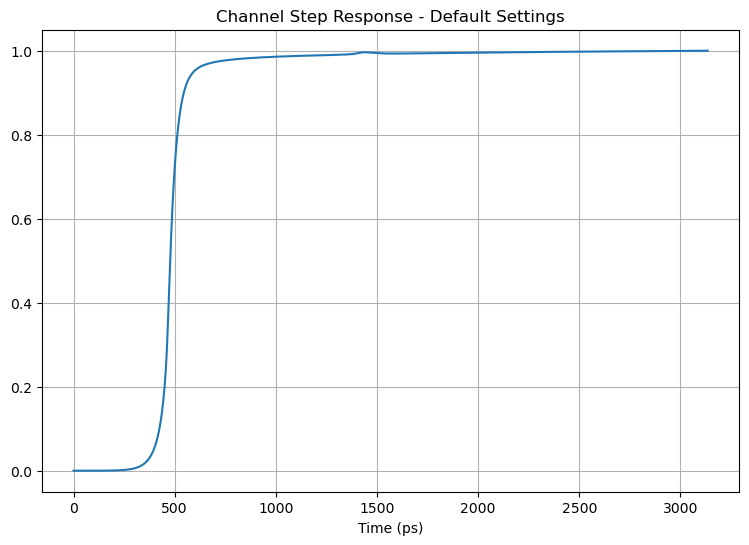

In [2]:
# Instantiate a PyBERT object and change any defaults as required.
myPyBERT = PyBERT(run_simulation=False,  # Need to adjust some properties first.
                  gui=False)             # Don't run stand-alone; we're in a notebook.
# myPyBERT.debug = True  # Uncomment to debug.
myPyBERT.l_ch     = 0.1    # The default (1 m) channel length causes an error.
myPyBERT.pn_freq  =    10  # (MHz)
myPyBERT.nbits    = 15000
myPyBERT.eye_bits = 10160  # 254 * 40

# Run the simulation and print out the resultant log for sanity checking.
my_run_simulation(myPyBERT,
                  initial_run=True,    # PyBERT does some "housekeeping" the first time through, which shouldn't be repeated.
                  update_plots=False)  # We'll do our own plotting, here in this notebook.
print(myPyBERT.console_log)

# Grab some resultant data needed below.
ui         = myPyBERT.ui                         # unit interval
nspb       = myPyBERT.nspb                       # samples per bit
t          = myPyBERT.t                          # simulation time vector
Ts         = t[1]                                # simulation sample interval
nbits      = myPyBERT.nbits                      # number of bits simulated
eye_bits   = myPyBERT.eye_bits                   # number of bits to use for eye plotting.
eye_uis    = myPyBERT.eye_uis                    # number of UIs to use for eye plotting.
ch_s       = myPyBERT.chnl_s                     # channel step response

print(f"UI: {ui*1e12:5.1f} ps")
print(f"Nspb: {nspb}")
print(f"Channel length: {myPyBERT.l_ch} m")
print(f"Channel ISI: {myPyBERT.isi_chnl*1e12} ps")

plt.plot(t[:len(ch_s)]*1e12, ch_s)
plt.title("Channel Step Response - Default Settings")
plt.xlabel("Time (ps)")
plt.grid()
plt.show()


### Sanity Check of PyBERT Jitter Analysis

Now, let's make sure the PyBERT jitter analysis behaves in a reasonable way.
We'll do that by varying the:

1. channel length (Should affect ISI.),
1. periodic noise level (Should affect _Pj_.), and
1. random noise level (Should affect _Rj_.).

For consistency, we'll look at the jitter in the _Rx input_, as that is the first point in the signal flow where _Pj_ and _Rj_ are introduced.

**Note:** We don't concern ourselves with DCD, because the PyBERT native Tx model doesn't include any output drive asymmetry.
(You can model this sort of asymmetry, using IBIS-AMI models, instead of PyBERT's native model.)

#### Channel Length Variation (ISI)

Here, we'll vary the channel length, to see its effect on the 3 jitter components.
We'll also plot the spectrum of the _total_ and _data independent_ jitter, which will enable us to do some sanity checking of our decomposition/analysis algorithm.

Channel length: 0.1 m; ISI:   4.0 ps; Pj:   0.0 ps; Rj:   0.5 ps.
Channel length: 0.2 m; ISI:   8.9 ps; Pj:   0.1 ps; Rj:   0.5 ps.
Channel length: 0.5 m; ISI:  33.5 ps; Pj:   0.1 ps; Rj:   0.5 ps.


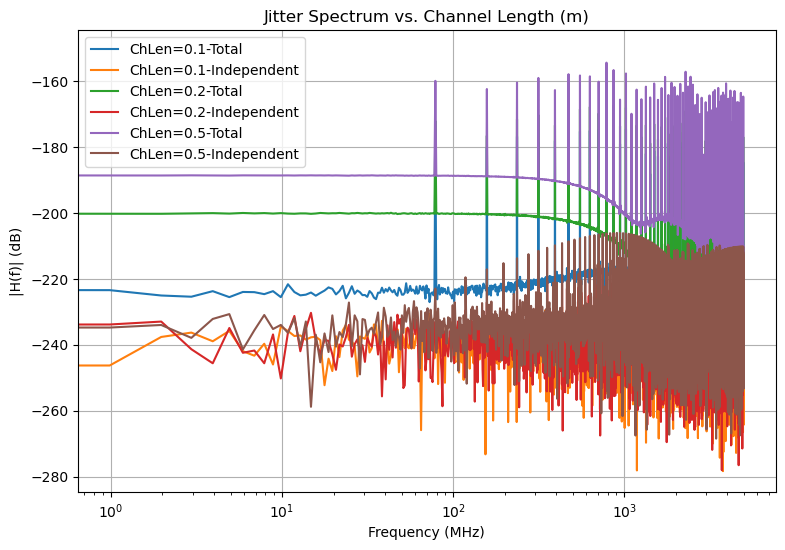

In [3]:
for l_ch in [0.1, 0.2, 0.5]:
    myPyBERT.l_ch = l_ch
    my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
    print(f"Channel length: {l_ch:3.1f} m; ISI: {myPyBERT.isi_tx*1e12:5.1f} ps; Pj: {myPyBERT.pj_tx*1e12:5.1f} ps; Rj: {myPyBERT.rj_tx*1e12:5.1f} ps.")
    plt.semilogx(myPyBERT.f_MHz[:len(myPyBERT.jitter_spectrum_tx)],     20*np.log10(np.abs(myPyBERT.jitter_spectrum_tx)),     label=f"ChLen={l_ch:3.1}-Total")
    plt.semilogx(myPyBERT.f_MHz[:len(myPyBERT.jitter_ind_spectrum_tx)], 20*np.log10(np.abs(myPyBERT.jitter_ind_spectrum_tx)), label=f"ChLen={l_ch:3.1}-Independent")
plt.title("Jitter Spectrum vs. Channel Length (m)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("|H(f)| (dB)")
plt.grid()
plt.legend()
plt.show()


All is as we expect:

1. ISI increases monotonically with channel length.

1. Pj is unaffected by channel length when no periodic noise exists.

1. Rj is unaffected by channel length when no random noise exists.

1. The jitter spectrum baseline rises with channel length and the total jitter has more spectral energy than just the data independent portion.

1. The harmonics of the bit pattern repetition frequency (approx. 80 MHz in this case) are dramatically diminished in the data independent case, due to the separation of data dependent and data independent jitter, via averaging.
Where we do see them (i.e. - in the 0.5 m channel length case), they are spaced half the pattern repetition frequency (approx. 40 MHz) apart, due to the way we do TIE averaging.
(We're forced to double the pattern, to cope with the needs of the duobinary and PAM-4 modulation schemes.)


#### Periodic Noise Variation

Here, we vary the amount of periodic noise added to the signal and see its effects on jitter analysis.

Periodic noise: 0.0 V; ISI:   8.9 ps; Pj:   0.0 ps; Rj:   0.5 ps.
Periodic noise: 0.1 V; ISI:   9.0 ps; Pj:   5.9 ps; Rj:   0.7 ps.
Periodic noise: 0.2 V; ISI:   9.4 ps; Pj:  11.4 ps; Rj:   1.0 ps.
Periodic noise: 0.3 V; ISI:   9.8 ps; Pj:  17.0 ps; Rj:   1.0 ps.


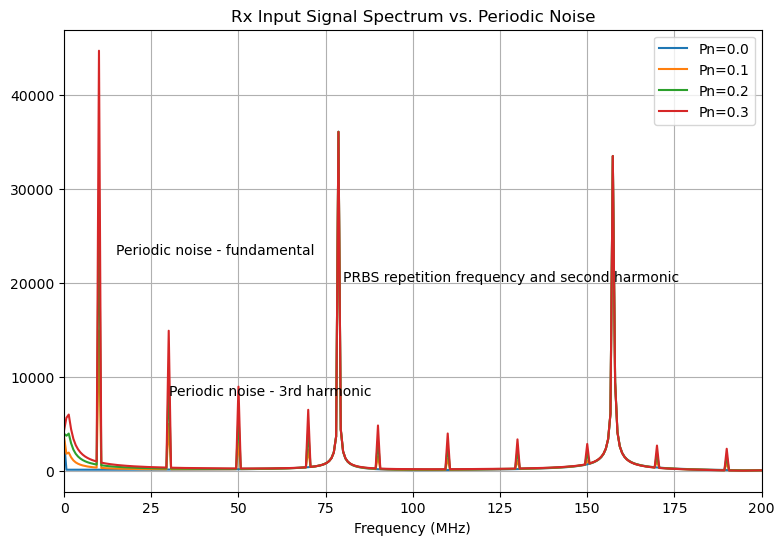

In [4]:
myPyBERT.l_ch = 0.2  # (m)

for pn_mag in [0.0, 0.1, 0.2, 0.3]:
    myPyBERT.pn_mag = pn_mag
    my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
    print(f"Periodic noise: {pn_mag:3.1f} V; ISI: {myPyBERT.isi_tx*1e12:5.1f} ps; Pj: {myPyBERT.pj_tx*1e12:5.1f} ps; Rj: {myPyBERT.rj_tx*1e12:5.1f} ps.")
    plt.plot(myPyBERT.f/1e6, np.abs(np.fft.fft(myPyBERT.rx_in))[:len(myPyBERT.f)],  label=f"Pn={pn_mag}")

plt.title("Rx Input Signal Spectrum vs. Periodic Noise")
plt.xlabel("Frequency (MHz)")
plt.text(80, 20100, "PRBS repetition frequency and second harmonic")
plt.text(15, 23000, "Periodic noise - fundamental")
plt.text(30,  8000, "Periodic noise - 3rd harmonic")
plt.axis(xmin=0, xmax=200)
plt.legend()
plt.grid()
plt.show()


Note the following in the plot above:

1. There is no variation with _Pn_ in the magnitude of the spikes at approximately 80 and 160 MHz.
That's because they represent the PRBS pattern repetition frequency, which is unaffected by periodic noise.

1. In the remaining spikes, the spectral energy varies as expected: increasing w/ increasing values of _Pn_.

1. Only the odd harmonics are present (i.e. - 10, 30, 50, etc. MHz), because the periodic noise is only a slight modification of a square wave.

Alright, the _signal_ spectrum looks correct; let's look at the _jitter_ spectrum.

/var/folders/pf/9gjf96y54f55tdz0vt0wq4kh0000gn/T/ipykernel_80637/894700243.py:3: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(np.abs(x))


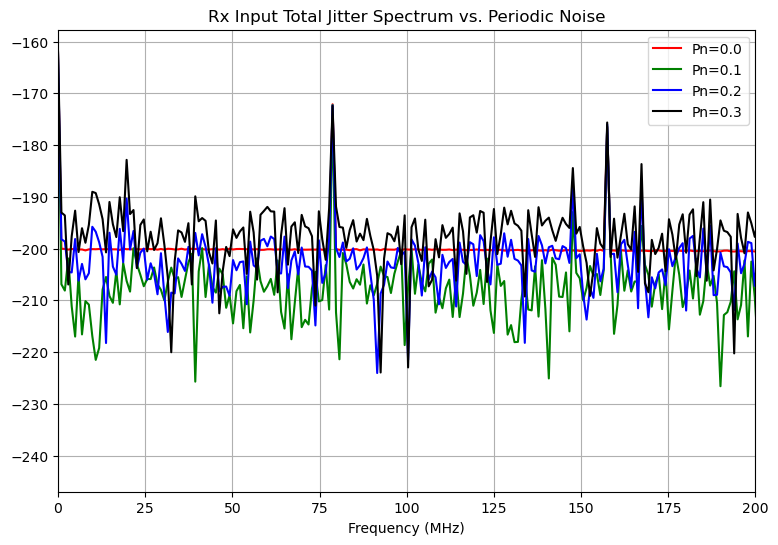

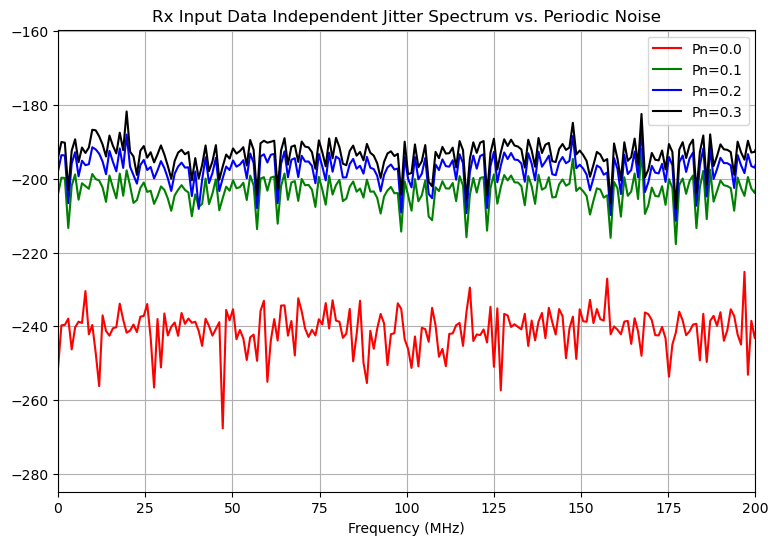

In [5]:
def dB(x):
    "Return magnitude of input vector in dB."
    return 20*np.log10(np.abs(x))

for (pn_mag, clr) in [(0.0, 'r'), (0.1, 'g'), (0.2, 'b'), (0.3, 'k')]:
    myPyBERT.pn_mag = pn_mag
    my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
    f_MHz = myPyBERT.f_MHz[:len(myPyBERT.jitter_spectrum_tx)]
    plt.figure(1)
    plt.plot(f_MHz, dB(myPyBERT.jitter_spectrum_tx),     clr, label=f"Pn={pn_mag}")
    plt.figure(2)
    plt.plot(f_MHz, dB(myPyBERT.jitter_ind_spectrum_tx), clr, label=f"Pn={pn_mag}")
    plt.plot(f_MHz, dB(myPyBERT.thresh_tx),             clr+'--')

plt.figure(1)
plt.title("Rx Input Total Jitter Spectrum vs. Periodic Noise")
plt.xlabel("Frequency (MHz)")
plt.axis(xmin=0, xmax=200)
plt.legend()
plt.grid()

plt.figure(2)
plt.title("Rx Input Data Independent Jitter Spectrum vs. Periodic Noise")
plt.xlabel("Frequency (MHz)")
plt.axis(xmin=0, xmax=200)
plt.legend()
plt.grid()

plt.show()


The spikes approximately 10 MHz to either side of the second harmonic of the pattern repetition frequency (i.e - approx. 160 MHz) are interesting.
They look like modulation products of the 10 MHz periodic noise fundamental on the second harmonic "carrier".
But, there's no explicit _mixing_ occurring in this portion of the PyBERT code.
The relationship between vertical noise and jitter is nonlinear.
I wonder if we're triggering that nonlinear behavior sufficiently to produce modulation.
I wouldn't have guessed so.

Where are the odd harmonics of the Pn frequency?!
I guess that actually makes sense, as the periodic additive noise (because it's very nearly a square wave) shifts the signal up and down.
But, the affect on jitter of an upward lift and a downward push are the same: both lengthen one half cycle while shortening the other.
That would explain why we see a spike at 20 MHz (twice the periodic noise frequency).
But, why is its magnitude so low and where are its harmonics?

Before moving on, let's test our modulation theory, by just changing the frequency of the periodic noise from 10 to 15 MHz, leaving everything else unchanged.

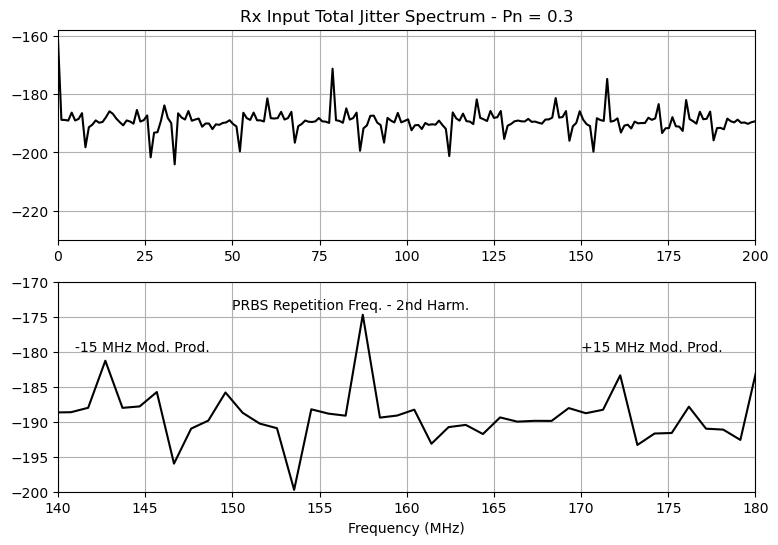

In [6]:
myPyBERT.pn_freq = 15
my_run_simulation(myPyBERT, initial_run=False, update_plots=False)

f_MHz = myPyBERT.f_MHz[:len(myPyBERT.jitter_spectrum_tx)]
plt.subplot(211)
plt.plot(f_MHz, dB(myPyBERT.jitter_spectrum_tx), 'k')
plt.subplot(212)
plt.plot(f_MHz, dB(myPyBERT.jitter_spectrum_tx), 'k')

plt.subplot(211)
plt.title("Rx Input Total Jitter Spectrum - Pn = 0.3")
plt.axis(xmin=0, xmax=200)
plt.grid()

plt.subplot(212)
plt.xlabel("Frequency (MHz)")
plt.text(150, -174, "PRBS Repetition Freq. - 2nd Harm.")
plt.text(141, -180, "-15 MHz Mod. Prod.")
plt.text(170, -180, "+15 MHz Mod. Prod.")
plt.axis(xmin=140, xmax=180, ymin=-200, ymax=-170)
plt.grid()

plt.show()


Okay, it definitely appears to be modulation of the PRBS repetition frequency second harmonic by the periodic noise source.
Interesting!

#### Random Noise Variation

Here, we vary the amount of random noise added to the signal and see its effects on jitter analysis.

Random noise: 0.0 V; ISI:  33.5 ps; Pj:   0.0 ps; Rj:   0.5 ps.
Random noise: 0.1 V; ISI:  33.7 ps; Pj:   0.3 ps; Rj:   1.2 ps.
Random noise: 0.2 V; ISI:  34.2 ps; Pj:   0.2 ps; Rj:   1.7 ps.
Random noise: 0.3 V; ISI:  35.1 ps; Pj:   0.7 ps; Rj:   2.4 ps.


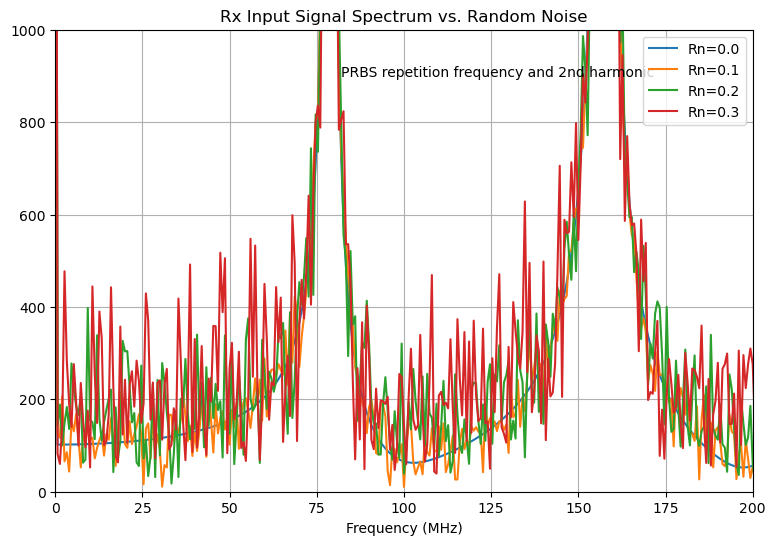

In [7]:
myPyBERT.l_ch    =  0.5  # (m)
myPyBERT.pn_mag  =  0
myPyBERT.pn_freq = 10
myPyBERT.thresh  =  6

for rn in [0.0, 0.1, 0.2, 0.3]:
    myPyBERT.rn = rn
    my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
    print(f"Random noise: {rn:3.1f} V; ISI: {myPyBERT.isi_tx*1e12:5.1f} ps; Pj: {myPyBERT.pj_tx*1e12:5.1f} ps; Rj: {myPyBERT.rj_tx*1e12:5.1f} ps.")
    plt.plot(myPyBERT.f/1e6, np.abs(np.fft.fft(myPyBERT.rx_in))[:len(myPyBERT.f)],  label=f"Rn={rn}")

plt.title("Rx Input Signal Spectrum vs. Random Noise")
plt.xlabel("Frequency (MHz)")
plt.text(82, 900, "PRBS repetition frequency and 2nd harmonic")
plt.axis(xmin=0, xmax=200, ymin=0, ymax=1000)
plt.legend()
plt.grid()
plt.show()


/var/folders/pf/9gjf96y54f55tdz0vt0wq4kh0000gn/T/ipykernel_80637/894700243.py:3: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(np.abs(x))


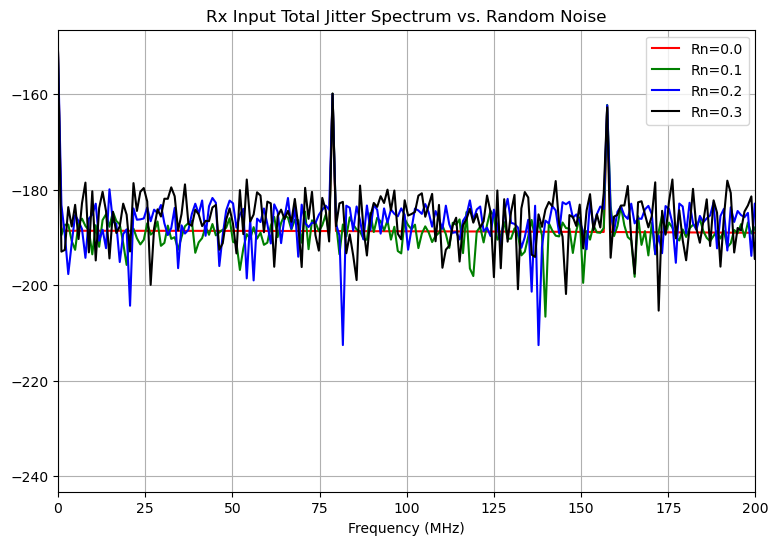

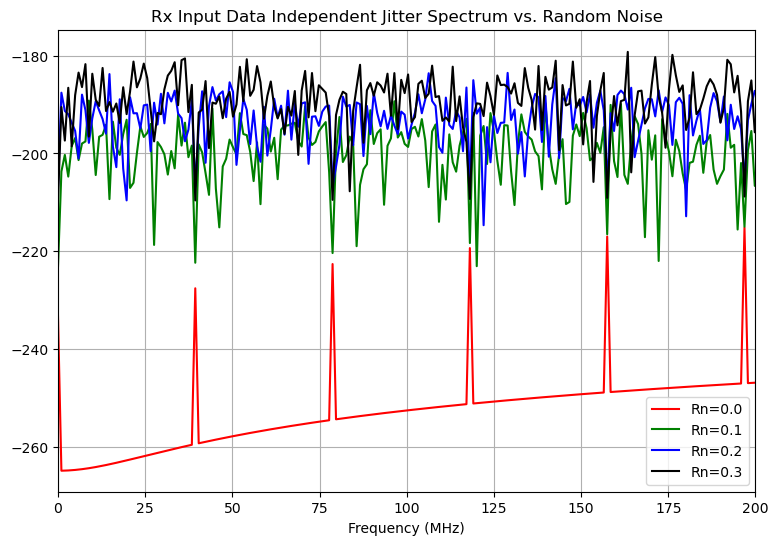

In [8]:
for (rn, clr) in [(0.0, 'r'), (0.1, 'g'), (0.2, 'b'), (0.3, 'k')]:
    myPyBERT.rn = rn
    my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
    f_MHz = myPyBERT.f_MHz[:len(myPyBERT.jitter_spectrum_tx)]
    plt.figure(1)
    plt.plot(f_MHz, dB(myPyBERT.jitter_spectrum_tx),     clr, label=f"Rn={rn}")
    plt.figure(2)
    plt.plot(f_MHz, dB(myPyBERT.jitter_ind_spectrum_tx), clr, label=f"Rn={rn}")
    plt.plot(f_MHz, dB(myPyBERT.thresh_tx),             clr+'--')

plt.figure(1)
plt.title("Rx Input Total Jitter Spectrum vs. Random Noise")
plt.xlabel("Frequency (MHz)")
plt.axis(xmin=0, xmax=200)
plt.legend()
plt.grid()

plt.figure(2)
plt.title("Rx Input Data Independent Jitter Spectrum vs. Random Noise")
plt.xlabel("Frequency (MHz)")
plt.axis(xmin=0, xmax=200)
plt.legend()
plt.grid()

plt.show()


Where are those large spikes at half the pattern repetition frequency coming from?
Clearly it's got something to do w/ my doubling of the effective pattern length before averaging, but what?

### Post-DFE Jitter

Let's check the jitter at the end of the signal processing chain, after the DFE, as we sweep the channel length.

We'll print the Rx input and post-CTLE jitter numbers, as well, so we can see what affect each step in the signal processing chain has on the various jitter components.

This time, we'll include some periodic and random noise, so we can see how increasing the channel length exaggerates the periodic and random jitter even though the magnitude of those noise sources remains constant.


In [9]:
myPyBERT.pn_mag = 0.1
myPyBERT.rn     = 0.3
for l_ch in [0.1, 0.2, 0.5]:
    myPyBERT.l_ch = l_ch
    my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
    print(f"Channel length: {l_ch:3.1f} m")
    print("\tStage\t\tISI (ps)\tPj (ps)\t\tRj (ps)")
    print("\t-------------------------------------------------------")
    print(f"\tRx In\t\t{myPyBERT.isi_tx*1e12:5.1f}\t\t{myPyBERT.pj_tx*1e12:5.1f}\t\t{myPyBERT.rj_tx*1e12:5.1f}")
    print(f"\tCTLE Out\t{myPyBERT.isi_ctle*1e12:5.1f}\t\t{myPyBERT.pj_ctle*1e12:5.1f}\t\t{myPyBERT.rj_ctle*1e12:5.1f}")
    print(f"\tDFE Out\t\t{myPyBERT.isi_dfe*1e12:5.1f}\t\t{myPyBERT.pj_dfe*1e12:5.1f}\t\t{myPyBERT.rj_dfe*1e12:5.1f}")
    print("")


Channel length: 0.1 m
	Stage		ISI (ps)	Pj (ps)		Rj (ps)
	-------------------------------------------------------
	Rx In		  4.6		  1.7		  1.7
	CTLE Out	  3.7		  0.9		  1.8
	DFE Out		  4.9		  0.8		  1.7

Channel length: 0.2 m
	Stage		ISI (ps)	Pj (ps)		Rj (ps)
	-------------------------------------------------------
	Rx In		  9.3		  5.3		  2.0
	CTLE Out	  8.0		  5.3		  2.0
	DFE Out		  6.5		  0.8		  2.0

Channel length: 0.5 m
	Stage		ISI (ps)	Pj (ps)		Rj (ps)
	-------------------------------------------------------
	Rx In		 35.5		  9.9		  1.0
	CTLE Out	 32.3		  9.8		  1.0
	DFE Out		 11.6		  0.5		  3.4



Several things are evident from the data above:

1. Increasing the channel length increases the periodic and random jitter, even though the magnitudes of the periodic and random noise sources remain constant.

    - This makes sense, since the degree of mapping from vertical noise to jitter is inversely proportional to the slope of the signal transition edges and a longer channel tends to reduce that slope, due to its lower bandwidth.
    
1. The DFE is a powerful ally in reducing all jitter components, particularly for longer channels.

### Curve Fitter Estimates of Pj

Just out of curiosity, I want to look at how the curve fitter estimates of _Pj_ compare to what I'm actually reporting, which is just the measurement of the separation between the two peaks in the smoothed histogram of the data independent jitter.

The curve fitter returns both the standard deviation and the mean of the Gaussian PDF that best fits the data.
And the difference between the two means _should_ be equal to Pj (i.e. - to our measurement of peak separation).

As above, all numbers are given in units of ps.

**Note:** The `dd_soltn` tuple is being passed back through a temporary debugging channel created specifically to aid in transitioning to dual Dirac Pj/Rj estimation.
For that reason, it may only apply to one point in the signal processing flow at a time (i.e. - channel, Tx, CTLE, or DFE).

In [10]:
for l_ch in [0.1, 0.2, 0.5]:
    myPyBERT.l_ch = l_ch
    my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
    mu_pos, sigma_pos, err_pos, mu_neg, sigma_neg, err_neg = myPyBERT.dd_soltn
    print(f"Channel length: {l_ch:3.1f} m")
    print("\tStage\t\tPj_meas.\tPj_est.")
    print("\t---------------------------------------")
    print(f"\tTx\t\t{myPyBERT.pj_tx*1e12:5.1f}\t\t{(mu_pos - mu_neg)*1e12:5.1f}")
    print("")


Channel length: 0.1 m
	Stage		Pj_meas.	Pj_est.
	---------------------------------------
	Tx		  3.4		  1.9

Channel length: 0.2 m
	Stage		Pj_meas.	Pj_est.
	---------------------------------------
	Tx		  4.2		  2.1

Channel length: 0.5 m
	Stage		Pj_meas.	Pj_est.
	---------------------------------------
	Tx		  9.7		  0.0



Hmmm, something's not right.
Let's look at the actual jitter distribution...

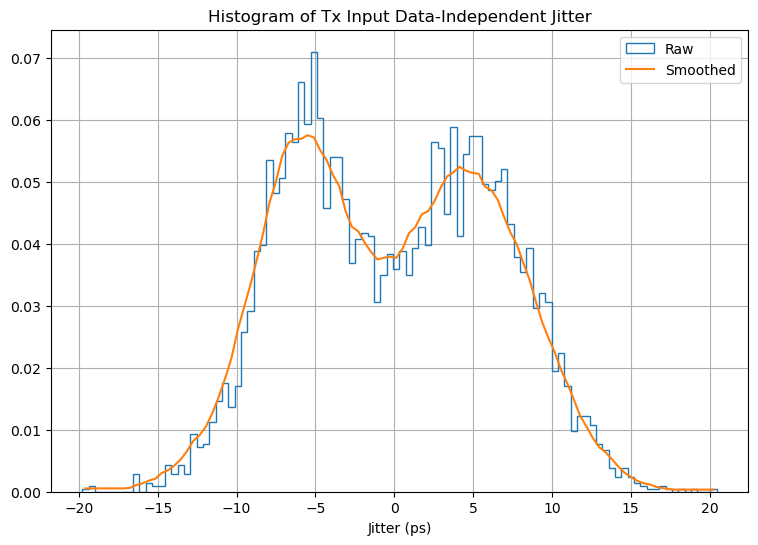

In [11]:
plt.hist(myPyBERT.tie_ind_tx*1e12, bins=100, histtype="step", density=True, label="Raw")
plt.plot(myPyBERT.centers, myPyBERT.hist_smooth, label="Smoothed")
plt.title("Histogram of Tx Input Data-Independent Jitter")
plt.xlabel("Jitter (ps)")
plt.grid()
plt.legend()
plt.show()


The smoothed histogram agrees with the _Pj_meas._ number, which is what I'm reporting in PyBERT, now.
I guess the curve fit to the bottom half of the tail can't really be expected to accurately locate the peaks, since the curve isn't Gaussian in that region, due to the "pollution" of the distribution by the periodic jitter there.

## Concluding Remarks

1. In general, the new "dual Dirac" algorithm for Pj/Rj separation seems to be performing correctly.
However, I'll wait for expert review of the new code, before merging it into the main development branch.

1. The modulation effect on the second harmonic of the PRBS repetition frequency by the periodic noise is very interesting.
It's not completely unexpected, since the mapping from vertical perturbation to jitter is _not_ completely linear.
And this non-linearity gets more pronounced with increasing vertical disturbance.
So, it makes sense that it is showing up most noticeably for greatest periodic noise magnitude.

1. The strong spectral spikes at half the PRBS pattern repetition frequency in the data independent jitter spectrum for the zero noise case are also very interestng.
They clearly are related to the pattern doubling I'm doing before averaging (to accomodate _duobinary_ and PAM-4 modulation schemes), but how exactly?
Obviously, they require a pristine zero noise environment in order to manifest.
So, they aren't affecting our results materially.
Still, though, rather interesting.